In [24]:
from functions import *

In [26]:
params = read_parameters()
subfolder = params['subfolder']
file_idx = params['file_idx'] # NB only [2,3,4] has concentrations
drop_initial_final_off_rows = params['drop_initial_final_off_rows']
drop_off_rows = params['drop_off_rows']
drop_outliers = params['drop_outliers']

In [50]:
ext_folder = '../data/extended/' + subfolder 
in_folder  = ext_folder + 'v1/'
out_folder = ext_folder + 'v2/'
in_files = [ (in_folder, file) for file in os.listdir(in_folder) if re.match(".*\.csv", file) ]

in_file = in_folder + in_files[file_idx][1]
out_file = re.sub('.csv', ' + conc.csv', out_folder + in_files[file_idx][1])

print("file list:")
for i in range(len(in_files)) :
    print(i, in_files[i][0] + in_files[i][1])
print(f"\ninput file:\n{in_file}")
print(f"\noutput file:\n{out_file}")

file list:
0 ../data/extended/UF/v1/2023-11-08 clean water.csv
1 ../data/extended/UF/v1/2023-11-09 0 clean water.csv
2 ../data/extended/UF/v1/2023-11-09 1 dirty water.csv
3 ../data/extended/UF/v1/2023-11-09 2 dirty water.csv
4 ../data/extended/UF/v1/2023-11-09 3 dirty water.csv
5 ../data/extended/UF/v1/2023-11-09 clean + dirty water.csv

input file:
../data/extended/UF/v1/2023-11-09 2 dirty water.csv

output file:
../data/extended/UF/v2/2023-11-09 2 dirty water + conc.csv


In [51]:
df = pd.read_csv(in_file)
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
DATE = df.loc[0, 'datetime'].date().isoformat()

In [52]:
x_axis   = ('time [m]', 'datetime')
x_format = (None,       '%H:%M')
TIME_MINS = 0
DATE_TIME = 1
TIME_IDX  = TIME_MINS

In [53]:
if drop_initial_final_off_rows :
    df = drop_initial_final_rows(df)

if drop_off_rows :
    df, df_OF = get_df_ON_OFF(df)
    print('removing OFF rows')
    print(" - dropped rows:", len(df_OF))
    del(df_OF)
    if drop_outliers :
        df, df_drop1 = remove_outliers(df, cols=['res tot [1/m]'], drop_fun=drop_outliers_far_median)
        df, df_drop2 = remove_outliers(df, cols=['flux [L/m^2h]'], drop_fun=drop_outliers_out_range)
        del(df_drop1, df_drop2)
else :
    print('showing all rows')

df = df.reset_index(drop=True)
df['time [m]'] = change_col_offset(df, 'time [m]')

removed 0 initial rows
removed 0 final rows
removing OFF rows
 - dropped rows: 0
removing outliers rows of column: res tot [1/m]
 - dropped rows: 0
removing outliers rows of column: flux [L/m^2h]
 - dropped rows: 0


(<Axes: xlabel='time [m]', ylabel='flux [LMH]'>,
 <Axes: title={'center': 'Flux and res over Time'}, ylabel='res tot [1/m]'>)

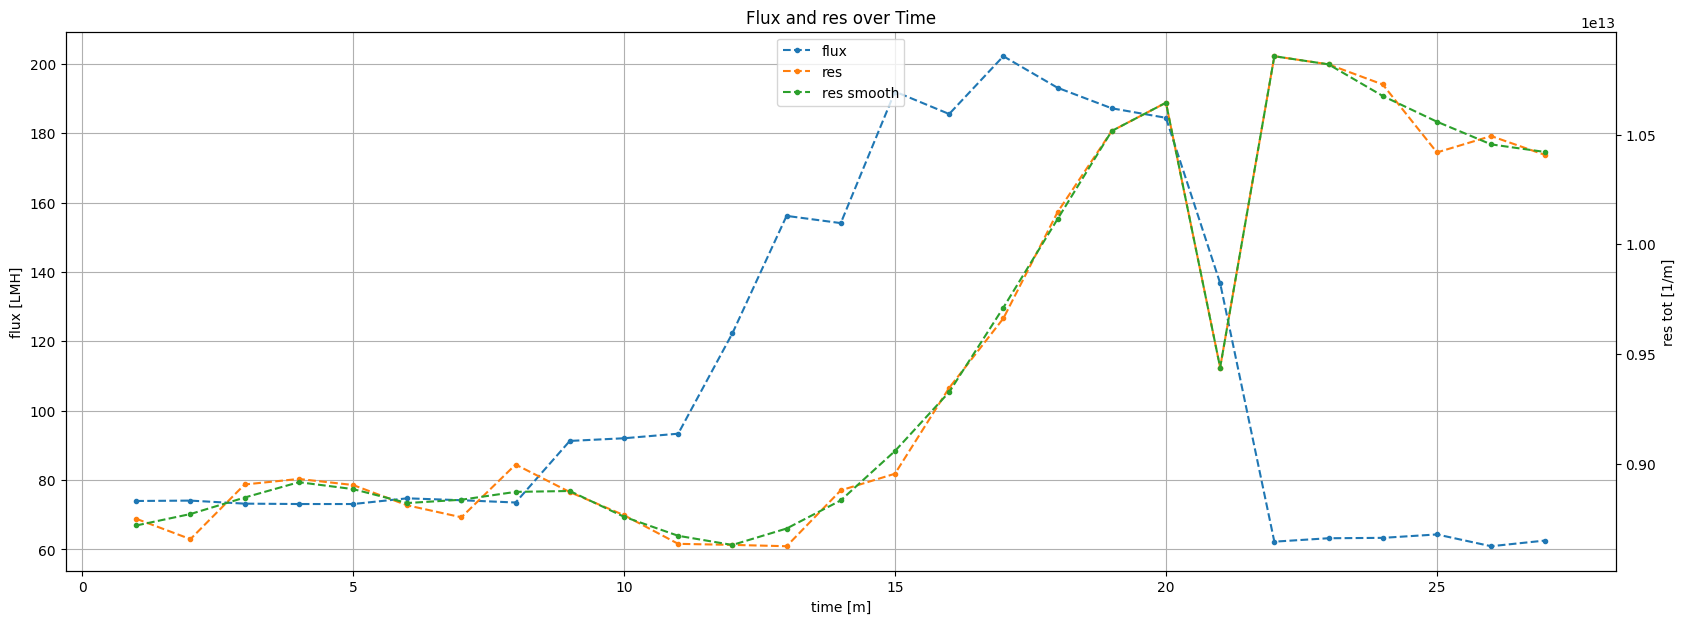

In [54]:
df = add_resistance_smooth_and_percentages(df)
y_dict = {
    'flux'          : df['flux [L/m^2h]'],
    'res'           : df['res tot [1/m]'],
    'res smooth'    : df['res tot smooth [1/m]']
}
y_ax_lbl = ['flux [LMH]', 'res tot [1/m]']
title    = 'Flux and res over Time'
plot_time_series_2_axis(x=df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_axis[TIME_IDX], y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[TIME_IDX], secondary_y=['res', 'res smooth'], loc='upper center')

In [57]:
df['feed concentration [g/L]'] = df['feed concentration [g/L]'].dropna()[0]

In [58]:
df['mass transfer coefficient'] = df.apply(lambda x : x['flux [L/m^2h]'] / math.log((x['retentate concentration [g/L]'] - x['permeate concentration [g/L]']) / (x['feed concentration [g/L]'] - x['permeate concentration [g/L]'])), axis = 1)

In [59]:
df[[
    'retentate concentration [g/L]', 
    'permeate concentration [g/L]', 
    'feed concentration [g/L]',
    'mass transfer coefficient',
]].dropna()

,retentate concentration [g/L],permeate concentration [g/L],feed concentration [g/L],mass transfer coefficient
0,0.712329,0.395180,1.296896,-70.800824
26,0.795978,0.289376,1.296896,-91.026713


In [20]:
# TODO automate the find of the good coefficient, now done manually
conc_coeffs = {
    # file_idx : { coeffs }
    2 : {
        'retentate' :   13.412, # conc_retentate_0 = 0.4970, conc_retentate_f = 0.5260 (?)
        'permeate'  :  -19.836, # conc_permeate_0  = 0.2764, conc_permeate_f  = 0.2542
    },
    3 : {
        'retentate' :   71.361, # conc_retentate_0 = 0.7123, conc_retentate_f = 0.7960
        'permeate'  : -152.637, # conc_permeate_0  = 0.3952, conc_permeate_f  = 0.2894
    },
    4 : {
        'retentate' :    92.974, # conc_retentate_0 = 1.2305, conc_retentate_f = 1.4467
        'permeate'  :  -187.900, # conc_permeate_0  = 0.4686, conc_permeate_f  = 0.3312
    }
}

In [21]:
# we have only initial and final data
# try to estimate concentration as d/dt res_tot
# df.loc[i, conc_est] = df.loc[i-1, conc_est] * (1 + (conc_coeffs[sample_type] * df.loc[i, dt_res_col]))
df = predict_concentration_given_coeff(df, conc_coeffs[file_idx])

In [22]:
# TODO EXPORT COEFFICIENTS TO CSV
# TODO READ COEFFICIENTS FROM CSV WITH ALL THE CONCENTRATIONS

In [ ]:
get_coeffs = (lambda obj, sample_type : [ x[sample_type] for x in obj.values()])
df_conc = pd.DataFrame()
df_conc['file_idx']                          = list(conc_coeffs.keys())
df_conc['retentate concentration t=0 [g/L]'] = [ 0.4970,  0.7123,  1.2305]
df_conc['permeate concentration t=0 [g/L]']  = [ 0.2764,  0.3952,  0.4686]
df_conc['coefficient retentate']             = get_coeffs(conc_coeffs, 'retentate')
df_conc['coefficient permeate']              = get_coeffs(conc_coeffs, 'permeate')
df_conc

,file_idx,retentate concentration t=0 [g/L],permeate concentration t=0 [g/L],coefficient retentate,coefficient permeate
0,2,0.4970,0.2764,13.412,-19.836
1,3,0.7123,0.3952,71.361,-152.637
2,4,1.2305,0.4686,92.974,-187.900


Intercept:    210.29993985868484
Coefficients: [152.45991067031625]
                              OLS Regression Results                             
Dep. Variable:     coefficient retentate   R-squared:                       0.997
Model:                               OLS   Adj. R-squared:                  0.994
Method:                    Least Squares   F-statistic:                     319.6
Date:                   Thu, 09 May 2024   Prob (F-statistic):             0.0356
Time:                           15:40:31   Log-Likelihood:                -6.1443
No. Observations:                      3   AIC:                             16.29
Df Residuals:                          1   BIC:                             14.49
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-------

/opt/conda/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/conda/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


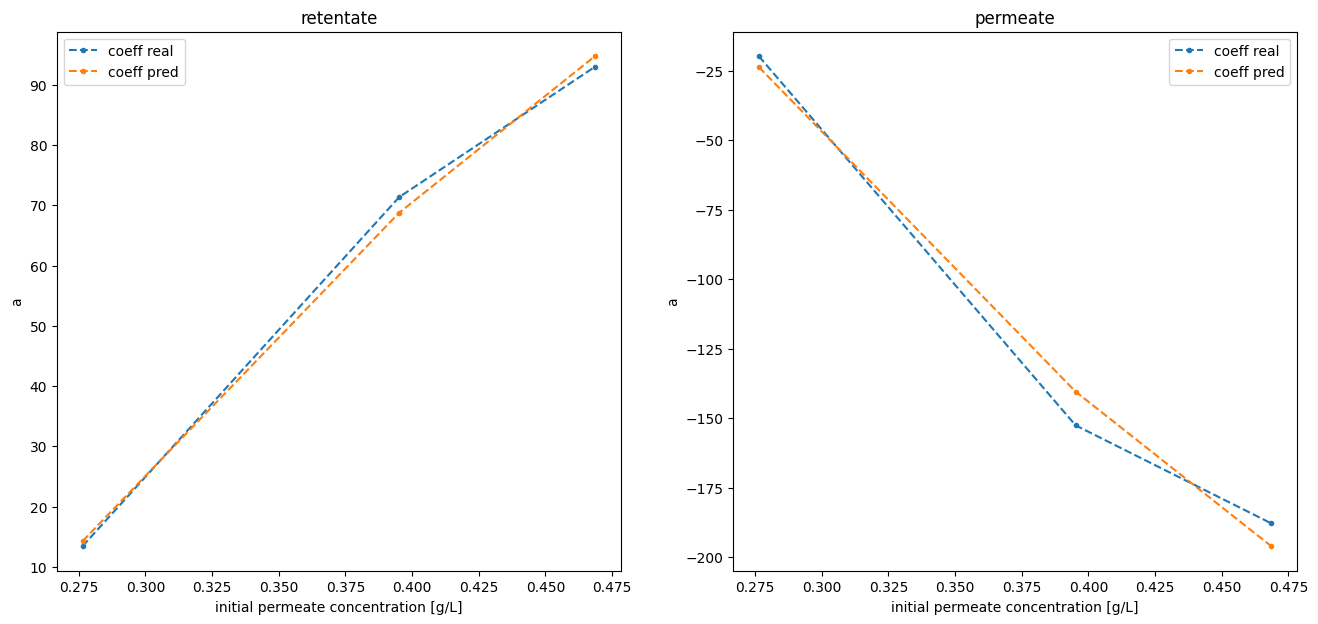

In [ ]:
y_series = {}
# estimate both using the permeate concentration
df_conc["log permeate concentration t=0 [g/L]"] = df_conc["permeate concentration t=0 [g/L]"].apply(lambda x : math.log(x))
x = df_conc[[f"log permeate concentration t=0 [g/L]"]]

coeffs_pred = {}

for sample_type in ['retentate', 'permeate'] :
    _, y_pred_conc, intercept_conc, coeffs_conc = call_linear_model(x, df_conc[f'coefficient {sample_type}'], summary=True)
    coeffs_pred[sample_type] = (intercept_conc, coeffs_conc)
    y_series[sample_type] = {
        'coeff real'  : df_conc[f'coefficient {sample_type}'],
        'coeff pred'  : y_pred_conc,
    }

x_series = [
    ('initial permeate concentration [g/L]', df_conc['permeate concentration t=0 [g/L]']),
    ('initial permeate concentration [g/L]', df_conc['permeate concentration t=0 [g/L]']),
]

plot_time_series_subplots(x_series, y_series, 'a', 'Estimating a : conc(t) = conc(t-1) * (1 + a * d/dt (res [%]))', x_format=None, s=3, rows=1, cols=2, figsize=(16,7))

In [ ]:
cur_conc_coeffs = get_initial_concentration_coefficients(df, coeffs_pred)
print('lm coeffs:', coeffs_pred)
print(cur_conc_coeffs)

lm coeffs: {'retentate': (210.29993985868484, [152.45991067031625]), 'permeate': (-443.6238887813249, [-326.51709000705085])}
{'retentate': 14.27545159576053, 'permeate': -23.806343327435968}


In [ ]:
def rename_cols(df, f_new_col, pattern_t='.*concentration est.*', pattern_f='.*v[0-9]*$') : 
    for c in df.columns :
        if re.match(pattern_t, c) and not re.match(pattern_f, c) :
            c_new = f_new_col(c)
            df = df.rename(columns={c : c_new})
            print(c, " -> ", c_new)
    return df

In [ ]:
df = rename_cols(df, f_new_col=(lambda x : x + ' v1'))
print('predicting with estimated coefficient...')
df = predict_concentration_given_coeff(df, cur_conc_coeffs)
df = rename_cols(df, f_new_col=(lambda x : x + ' v2'))

retentate concentration est [g/L]  ->  retentate concentration est [g/L] v1
retentate concentration est ratio  ->  retentate concentration est ratio v1
permeate concentration est [g/L]  ->  permeate concentration est [g/L] v1
permeate concentration est ratio  ->  permeate concentration est ratio v1
predicting with estimated coefficient...
retentate concentration est [g/L]  ->  retentate concentration est [g/L] v2
retentate concentration est ratio  ->  retentate concentration est ratio v2
permeate concentration est [g/L]  ->  permeate concentration est [g/L] v2
permeate concentration est ratio  ->  permeate concentration est ratio v2


In [ ]:
df[[
    'retentate concentration [g/L]', 
    'retentate concentration est [g/L] v1', 'retentate concentration est ratio v1',
    'retentate concentration est [g/L] v2', 'retentate concentration est ratio v2', 
    'permeate concentration [g/L]', 
    'permeate concentration est [g/L] v1', 'permeate concentration est ratio v1',
    'permeate concentration est [g/L] v2', 'permeate concentration est ratio v2'
]].dropna()

,retentate concentration [g/L],retentate concentration est [g/L] v1,retentate concentration est ratio v1,retentate concentration est [g/L] v2,retentate concentration est ratio v2,permeate concentration [g/L],permeate concentration est [g/L] v1,permeate concentration est ratio v1,permeate concentration est [g/L] v2,permeate concentration est ratio v2
0,0.497025,0.497025,1.00000,0.497025,1.000000,0.276445,0.276445,1.0,0.276445,1.000000
45,0.525992,0.525987,0.99999,0.527906,1.003638,0.254166,0.254166,1.0,0.249918,0.983285


In [ ]:
df.columns

Index(['datetime', 'time span [s]', 'time [m]', 'prs input [kPa]',
       'prs feed_1 [kPa]', 'prs feed_2 [kPa]', 'prs permeate [kPa]',
       'prs retentate [kPa]', 'TMP [kPa]', 'temperature [°C]',
       'viscosity permeate [Pa s]', 'tank liters [L]', 'tank liters [%]',
       'flow feed [L/h]', 'flow permeate [L/h]', 'flow retentate [L/h]',
       'area tot [m^2]', 'flux [L/m^2h]', 'res tot [1/m]', 'is_ON',
       'vol feed [L]', 'vol permeate [L]', 'delta vol permeate [L]',
       'increased TMP', 'decreased TMP', 'starting', 'jumped temperature',
       'changed TMP', 'res tot smooth [1/m]', 'res [%]', 'd/dt res [%]'],
      dtype='object')

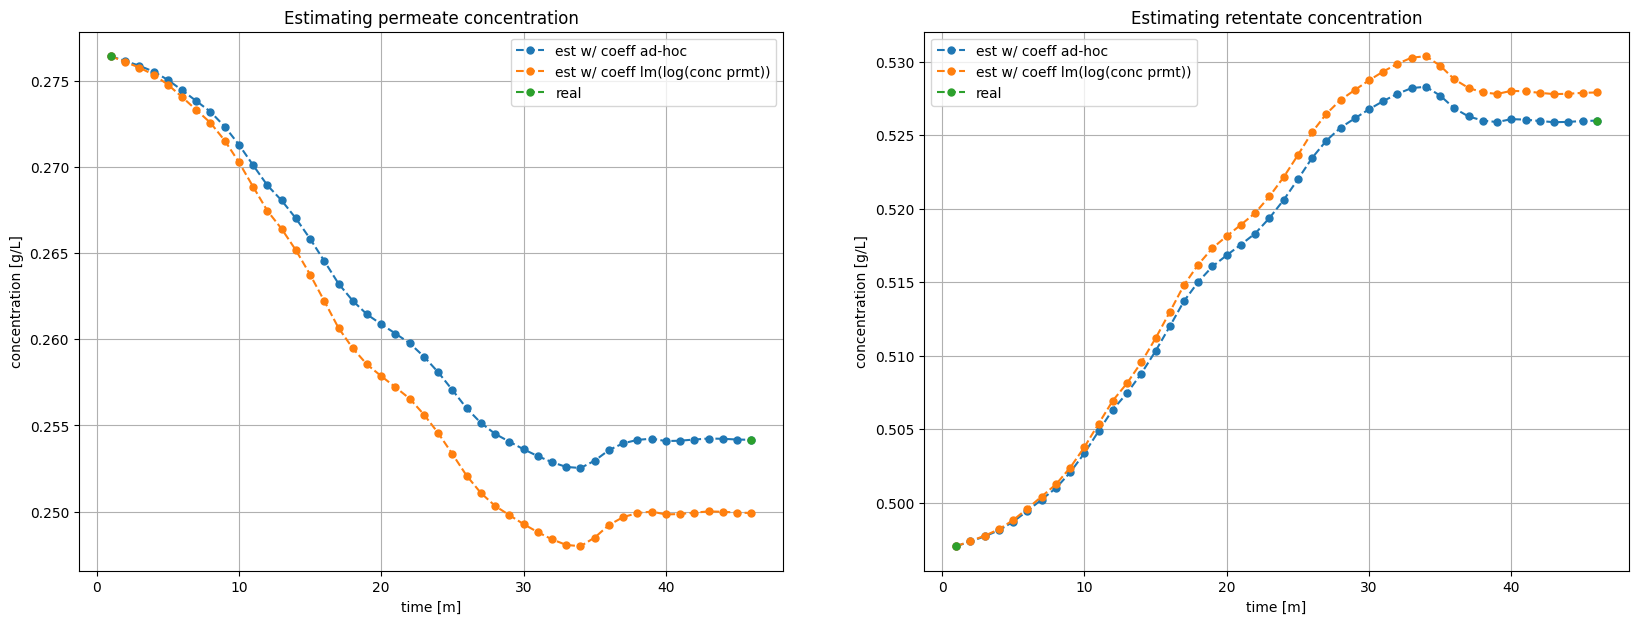

In [18]:
y_ss = {}
y_ss['Estimating permeate concentration'] = {
    'est w/ coeff ad-hoc'              : df['permeate concentration est [g/L] v1'],
    'est w/ coeff lm(log(conc prmt))'  : df['permeate concentration est [g/L] v2'],
    'real'                             : df['permeate concentration [g/L]'],
}
y_ss['Estimating retentate concentration'] = {
    'est w/ coeff ad-hoc'              : df['retentate concentration est [g/L] v1'],
    'est w/ coeff lm(log(conc prmt))'  : df['retentate concentration est [g/L] v2'],
    'real'                             : df['retentate concentration [g/L]'],
}
x_series = [
    ('time [m]', df[x_axis[TIME_IDX]]),
    ('time [m]', df[x_axis[TIME_IDX]])
]
plot_time_series_subplots(x_series, y_ss, 'concentration [g/L]', 'Estimating concentrations', x_format=None, s=5, figsize=(20,7), rows=1, cols=2)


In [19]:
df.to_csv(out_file, index=False)

In [20]:
for t in ['retentate', 'permeate'] :
    write_estimated_coefficients_to_json(FILE_EST_COEFFS, key=f'concentration {t}', x_cols=["log permeate concentration [g/L]"], intercept=coeffs_pred[t][0], coefficients=coeffs_pred[t][1])

In [21]:
# with open(FILE_EST_COEFFS, 'r') as f:
#     data = json.load(f)
#     data['concentration coefficients'] = {
#         'retentate' : {
#             'x'            : ["log permeate concentration [g/L]"],
#             'intercept'    : coeffs_pred['retentate'][0],
#             'coefficients' : list(coeffs_pred['retentate'][1])
#         },
#         'permeate' : {
#             'x'            : ["log permeate concentration [g/L]"],
#             'intercept'    : coeffs_pred['permeate'][0],
#             'coefficients' : list(coeffs_pred['permeate'][1])
#         }
#     }

# with open(FILE_EST_COEFFS, "w") as f:
#     json.dump(data, f, indent=4)